In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save

In [5]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
                'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [6]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [7]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

In [8]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

ConnectionError: HTTPSConnectionPool(host='en.wikipedia.org', port=443): Max retries exceeded with url: /wiki/List_of_battles_1601%E2%80%931800 (Caused by NewConnectionError('<requests.packages.urllib3.connection.VerifiedHTTPSConnection object at 0x7fb640de8f50>: Failed to establish a new connection: [Errno -2] Name or service not known',))

In [9]:
link_list

[]

In [12]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [13]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [14]:
df_late_battles

,url,Battle
0,/wiki/List_of_battles_before_301,List of battles before 301
1,/wiki/List_of_battles_301%E2%80%931300,List of battles 301–1300
2,/wiki/List_of_battles_1301%E2%80%931600,List of battles 1301–1600
3,/wiki/List_of_battles_1801-1900,List of battles 1801-1900
4,/wiki/List_of_battles_1901-2000,List of battles 1901-2000
5,/wiki/List_of_battles_2001-current,List of battles 2001-current
6,/wiki/List_of_naval_battles,List of naval battles
7,/wiki/List_of_sieges,List of sieges
8,/wiki/Battle_of_Bantam,Battle of Bantam
10,/wiki/Siege_of_Nagykanizsa,Siege of Nagykanizsa


In [15]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

TypeError: bad operand type for unary ~: 'float'

In [16]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [17]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [18]:
df_late_battles.head()

,Column1,Column2,Column3,Column4
0,NaN,url,Battle,NaN
1,0.0,/wiki/Battle_of_Bantam,Battle_of_Bantam,NaN
2,2.0,/wiki/Siege_of_Nagykanizsa,Siege_of_Nagykanizsa,NaN
3,3.0,/wiki/Battle_of_Sluis_(1603),Battle_of_Sluis_(1603),NaN
4,5.0,/wiki/Battle_of_Bra%C8%99ov,Battle_of_Brasov,NaN


In [19]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [20]:
battle_list = []
link_list = []

In [8]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [22]:
for page in table_pages:
    print page
    early_battles(page)

https://en.wikipedia.org/wiki/List_of_battles_before_301
200
https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300
200
https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600
200
https://en.wikipedia.org/wiki/List_of_battles_since_2001
200


In [23]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [24]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [25]:
len(df_battles)

1602

In [26]:
len(df_late_battles)

1990

In [27]:
df_battles.head()

,Battle,url
0,Battle of Banquan,/wiki/Battle_of_Banquan
1,Battle of Zhuolu,/wiki/Battle_of_Zhuolu
2,Battle of Uruk,/wiki/Battle_of_Uruk
3,Battle of Mingtiao,/wiki/Battle_of_Mingtiao
4,Battle of the Ten Kings,/wiki/Battle_of_the_Ten_Kings


In [28]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [29]:
len(df_url)

3592

In [30]:
len(df_url.drop_duplicates())

3580

In [31]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [32]:
if ul is not None:
    print 'works'

In [9]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:


        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

<ipython-input-9-9340181b980a>:191: SyntaxWarning: name 'df_battle_all' is assigned to before global declaration
  global df_battle_all


In [10]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

<ipython-input-10-092b1f644c94>:24: SyntaxWarning: name 'count' is assigned to before global declaration
  global count


NameError: name 'df_url' is not defined

In [9]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [10]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [11]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [12]:
len(df_comm)

113974

In [13]:
len(df_comm)

113974

In [14]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [11]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [12]:
df_comm = df_comm.drop_duplicates()

In [13]:
df_comm.head()

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken
0,Siege_of_Nagykanizsa,9 September 1601 – 18 November 1601,"Naģykanizsa, Ottoman Empire",Decisive Ottoman victory,Tiryaki Hasan Pasha,Heavy losses[2]\n3000 sick and wounded[1],"35,000[1]\n40+ cannon","9,000\n100 small cannon",L,Unknown
1,Siege_of_Nagykanizsa,9 September 1601 – 18 November 1601,"Naģykanizsa, Ottoman Empire",Decisive Ottoman victory,"Ferdinand II, Holy Roman Emperor",Unknown,"9,000\n100 small cannon","35,000[1]\n40+ cannon",R,Heavy losses[2]\n3000 sick and wounded[1]
2,Battle_of_Sluis_(1603),26 May 1603,Sluis (present-day Netherlands),Dutch victory,Joos de Moor,414 killed[3](Spanish source)\n800 dead or wou...,"8 Galleys,\n1,130 soldiers[1](Spanish source)\...","3 men-of-war,\n2 galleys,\nseveral minor vesse...",L,"720 killed,\n1 man-of-war sunk[3](Spanish sour..."
3,Battle_of_Sluis_(1603),26 May 1603,Sluis (present-day Netherlands),Dutch victory,Federico Spinola,"720 killed,\n1 man-of-war sunk[3](Spanish sour...","3 men-of-war,\n2 galleys,\nseveral minor vesse...","8 Galleys,\n1,130 soldiers[1](Spanish source)\...",R,414 killed[3](Spanish source)\n800 dead or wou...
4,Battle_of_Brasov,"July 17, 1603",Braşov\n45°39′N 25°36′E﻿ / ﻿45.650°N 25.600°E﻿...,NaN,Radu Șerban,NaN,unknown,unknown,L,NaN


In [138]:
len(df_comm)

12161

In [139]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken
34638,Suez_Crisis,29 October 1956 (1956-10-29) – 7 November 1956...,Gaza Strip and Egypt (Sinai and Suez Canal zone),Coalition military victory;[1][2][3]\nEgyptian...,Gamal Abdel Nasser,Israel:\n\n\n231 killed[9]\n899 wounded\n4 cap...,"175,000\n 45,000\n 34,000","300,000[8]",R,"1,650[11][12]–3,000 killed[13]\n1,000 civilian..."
34742,Six_Day_War,"June 5–10, 1967 (6 days)",Middle East,Decisive Israeli victory,Gamal Abdel Nasser,"776[6]–983[7] killed\n4,517 wounded\n15 captur...","50,000 troops\n214,000 reserves\n300 combat ai...","Egypt: 240,000\nSyria, Jordan, and Iraq: 307,0...",R,"Egypt: 10,000[9]–15,000[10] killed or missing\..."
113565,Battle of Nablus,"April 3–8, 2002","Nablus, Palestinian Authority (West Bank)",Israeli victory,Nasser Badawi,1 killed[3],2 regular infantry brigades\n1 reserve armored...,"1,000+[2]",R,70 killed\nHundreds captured[4]
113566,Battle of Nablus,"April 3–8, 2002","Nablus, Palestinian Authority (West Bank)",Israeli victory,Nasser Awais,1 killed[3],2 regular infantry brigades\n1 reserve armored...,"1,000+[2]",R,70 killed\nHundreds captured[4]


In [140]:
len(df_comm.drop_duplicates())

12161

In [141]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [142]:
df_comm.to_csv('battles_deduped.csv')

In [143]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

53

In [144]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken
7626,Battle of Camerinum,298 BC,"Camerinum (modern Camerino), Italy",Samnite victory,Lucius Cornelius Scipio Barbatus,NaN,unknown,unknown,L,NaN
7628,Battle of Tifernum,297 BC,"Città di Castello (Perugia, Umbria), Italy",Roman victory,Lucius Cornelius Scipio Barbatus,"3,400 dead,\n830 captured","25,000","20,000",L,"2,000 dead"
7662,Battle of the Lipara Islands,260 BC,"Lipara harbour, Sicily",Carthaginian victory,Gnaeus Cornelius Scipio Asina,4 ships,20 ships,17 ships,R,17 ships captured
7713,Battle of the Ticinus,"November, 218 BC","Right bank of lower Ticino River, present-day ...",Carthaginian victory,Publius Cornelius Scipio,minimal,"6,000 cavalry","3,100 cavalry\n7,200 velites",R,"2,300"
7716,Battle of Cissa,Fall 218 BC,"Cissa or Tarraco, present-day Spain",Roman victory,Gnaeus Cornelius Scipio Calvus,"6,000 killed,\n2,000 captured","10,000 infantry,\n1,000 cavalry","20,000 infantry,\n2,200 cavalry",R,unknown
7721,Battle of Ebro River,"Spring, 217 BC","Mouth of Ebro River, present-day Spain",Decisive Roman victory,Gnaeus Cornelius Scipio Calvus,"4 sunk,\n25 captured",40 Quinqueremes,55 Quinqueremes and Triremes,R,Unknown
7738,Battle of Dertosa,Spring 215 BC,"Tortosa, present-day Spain",Roman victory,Gnaeus Cornelius Scipio Calvus,Heavy,"29,000:\n25,000 infantry,\n4,000 cavalry,\n20 ...","32,800:\n30,000 infantry,\n2,800 cavalry",L,Unknown
7739,Battle of Dertosa,Spring 215 BC,"Tortosa, present-day Spain",Roman victory,Publius Cornelius Scipio,Heavy,"29,000:\n25,000 infantry,\n4,000 cavalry,\n20 ...","32,800:\n30,000 infantry,\n2,800 cavalry",L,Unknown
7766,Battle of the Upper Baetis,211 BC,Near Upper Baetis (modern-day Guadalquivir) Ri...,Carthaginian victory,Publius Cornelius Scipio,Unknown,"Total: 48,500,\n35,000 infantry,\n3,000+ caval...","Total: 53,000,\n30,000 infantry,\n3,000 cavalr...",R,"About 22,000"
7767,Battle of the Upper Baetis,211 BC,Near Upper Baetis (modern-day Guadalquivir) Ri...,Carthaginian victory,Gnaeus Cornelius Scipio Calvus,Unknown,"Total: 48,500,\n35,000 infantry,\n3,000+ caval...","Total: 53,000,\n30,000 infantry,\n3,000 cavalr...",R,"About 22,000"


In [145]:
df_results = pd.read_csv('result_column.csv')

In [146]:
df_results[df_results.Battle == 'Battle_of_Camarón']

,Battle,belligerent,pos,Result,VorD
2987,Battle_of_Camarón,Francisco de Paula Milán,L,Tactical Mexican victory\nStrategic French vic...,V
2988,Battle_of_Camarón,Jean Danjou,R,Tactical Mexican victory\nStrategic French vic...,D
2989,Battle_of_Camarón,Jean Vilain — Wikipédia,R,Tactical Mexican victory\nStrategic French vic...,D
2990,Battle_of_Camarón,Clément Maudet — Wikipédia,R,Tactical Mexican victory\nStrategic French vic...,D


In [147]:
df_comm.head()

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken
0,Siege_of_Nagykanizsa,9 September 1601 – 18 November 1601,"Naģykanizsa, Ottoman Empire",Decisive Ottoman victory,Tiryaki Hasan Pasha,Heavy losses[2]\n3000 sick and wounded[1],"35,000[1]\n40+ cannon","9,000\n100 small cannon",L,Unknown
1,Siege_of_Nagykanizsa,9 September 1601 – 18 November 1601,"Naģykanizsa, Ottoman Empire",Decisive Ottoman victory,"Ferdinand II, Holy Roman Emperor",Unknown,"9,000\n100 small cannon","35,000[1]\n40+ cannon",R,Heavy losses[2]\n3000 sick and wounded[1]
2,Battle_of_Sluis_(1603),26 May 1603,Sluis (present-day Netherlands),Dutch victory,Joos de Moor,414 killed[3](Spanish source)\n800 dead or wou...,"8 Galleys,\n1,130 soldiers[1](Spanish source)\...","3 men-of-war,\n2 galleys,\nseveral minor vesse...",L,"720 killed,\n1 man-of-war sunk[3](Spanish sour..."
3,Battle_of_Sluis_(1603),26 May 1603,Sluis (present-day Netherlands),Dutch victory,Federico Spinola,"720 killed,\n1 man-of-war sunk[3](Spanish sour...","3 men-of-war,\n2 galleys,\nseveral minor vesse...","8 Galleys,\n1,130 soldiers[1](Spanish source)\...",R,414 killed[3](Spanish source)\n800 dead or wou...
4,Battle_of_Brasov,"July 17, 1603",Braşov\n45°39′N 25°36′E﻿ / ﻿45.650°N 25.600°E﻿...,NaN,Radu Șerban,NaN,unknown,unknown,L,NaN


In [148]:
df_results.head()

,Battle,belligerent,pos,Result,VorD
0,Siege_of_Nagykanizsa,Tiryaki Hasan Pasha,L,Decisive Ottoman victory,V
1,Siege_of_Nagykanizsa,"Ferdinand II, Holy Roman Emperor",R,Decisive Ottoman victory,D
2,Battle_of_Sluis_(1603),Joos de Moor,L,Dutch victory,V
3,Battle_of_Sluis_(1603),Federico Spinola,R,Dutch victory,D
4,Battle_of_Dobrynichi,False Dmitry I,L,Russian decisive victory,L


In [164]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [165]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [166]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [167]:
df_more_results.head()

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken,VorD
4,Battle_of_Brasov,"July 17, 1603",Braşov\n45°39′N 25°36′E﻿ / ﻿45.650°N 25.600°E﻿...,NaN,Radu Șerban,NaN,unknown,unknown,L,NaN,NaN
20,Battle_of_Kluszyn,4 July 1610,Klushino,Decisive Polish victory,Stanisław Żółkiewski,"5,000[2]","30,000 Russians[2][3]\nand 5,000 mercenaries\n...","6,500–6,800 men[1][2]\n\n2 guns[2]",L,400[2],NaN
124,Siege_of_Recife_(1630),1601–1663,"Atlantic Ocean: Brazil, West Africa, Southern ...",Treaty of Hague\n\nFormation of the Dutch Empi...,"Matias de Albuquerque, Count of Alegrete",NaN,unknown,unknown,L,NaN,NaN
139,Sack_of_Magdeburg,20 May 1631,Magdeburg\n52°08′N 11°37′E﻿ / ﻿52.133°N 11.617...,Destruction of the city,Sweden,"300 killed\n1,600 wounded[1]","24,000","2,400",R,"25,000 inhabitants[1]",NaN
178,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\n(present-...",Decisive Imperial-Spanish victory[1],Sweden,"2,400 dead or wounded[5]","21,000 infantry and 13,000 cavalry (32 guns)","16,300 infantry and 9,300 cavalry (62 guns)",L,"8,000 dead or wounded\n4,000 captured[1][3][4]",NaN


In [174]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [35]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken
3192,Battle_of_Camarón,30 April 1863,"Camarón, near Palo Verde, Mexico",Tactical Mexican victory\nStrategic French vic...,Francisco de Paula Milán,43 killed\n19 captured of whom 17 were wounded...,3 Foreign Legion Officers\n62 Legionnaires,"800 cavalry\n2,200 infantry",L,190 killed\n300+ wounded
3193,Battle_of_Camarón,30 April 1863,"Camarón, near Palo Verde, Mexico",Tactical Mexican victory\nStrategic French vic...,Jean Danjou,190 killed\n300+ wounded,"800 cavalry\n2,200 infantry",3 Foreign Legion Officers\n62 Legionnaires,R,43 killed\n19 captured of whom 17 were wounded...
3194,Battle_of_Camarón,30 April 1863,"Camarón, near Palo Verde, Mexico",Tactical Mexican victory\nStrategic French vic...,Jean Vilain — Wikipédia,190 killed\n300+ wounded,"800 cavalry\n2,200 infantry",3 Foreign Legion Officers\n62 Legionnaires,R,43 killed\n19 captured of whom 17 were wounded...
3195,Battle_of_Camarón,30 April 1863,"Camarón, near Palo Verde, Mexico",Tactical Mexican victory\nStrategic French vic...,Clément Maudet — Wikipédia,190 killed\n300+ wounded,"800 cavalry\n2,200 infantry",3 Foreign Legion Officers\n62 Legionnaires,R,43 killed\n19 captured of whom 17 were wounded...


In [21]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken
9181,Battle of La Brossinière,26 September 1423,"La Brossinière, France",French victory,Ambroise de Loré,"800-1,700 killed\r\r\n30 captured, including J...",2 000 soldiers\r\r\n800 archers,"6,000",L,1 knight\r\r\nand a few others (of no title)


In [15]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [16]:
df_vl

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken,VorD
0,Siege_of_Nagykanizsa,9 September 1601 – 18 November 1601,"Naģykanizsa, Ottoman Empire",Decisive Ottoman victory,Tiryaki Hasan Pasha,Heavy losses[2]\r\r\n3000 sick and wounded[1],"35,000[1]\r\r\n40+ cannon","9,000\r\r\n100 small cannon",L,Unknown,V
1,Siege_of_Nagykanizsa,9 September 1601 – 18 November 1601,"Naģykanizsa, Ottoman Empire",Decisive Ottoman victory,"Ferdinand II, Holy Roman Emperor",Unknown,"9,000\r\r\n100 small cannon","35,000[1]\r\r\n40+ cannon",R,Heavy losses[2]\r\r\n3000 sick and wounded[1],D
2,Battle_of_Sluis_(1603),26 May 1603,Sluis (present-day Netherlands),Dutch victory,Joos de Moor,414 killed[3](Spanish source)\r\r\n800 dead or...,"8 Galleys,\r\r\n1,130 soldiers[1](Spanish sour...","3 men-of-war,\r\r\n2 galleys,\r\r\nseveral min...",L,"720 killed,\r\r\n1 man-of-war sunk[3](Spanish ...",V
3,Battle_of_Sluis_(1603),26 May 1603,Sluis (present-day Netherlands),Dutch victory,Federico Spinola,"720 killed,\r\r\n1 man-of-war sunk[3](Spanish ...","3 men-of-war,\r\r\n2 galleys,\r\r\nseveral min...","8 Galleys,\r\r\n1,130 soldiers[1](Spanish sour...",R,414 killed[3](Spanish source)\r\r\n800 dead or...,D
4,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\n52°16′56″N 34°20′...",Russian decisive victory,False Dmitry I,?,"20,000","23,000",L,?,L
5,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\n52°16′56″N 34°20′...",Russian decisive victory,Fyodor Mstislavsky,?,"23,000","20,000",R,?,W
6,Battle_of_Kircholm,"September 17, 1605 (O.S.)\r\r\nSeptember 27, 1...","Kircholm, present-day Salaspils, Latvia",Decisive Polish-Lithuanian victory,Jan Karol Chodkiewicz,"7,600–8,000 killed, captured and dispersed[2]","10,868:[1]:64\r\r\n2,500 cavalry\r\r\n8,368 in...","3,600:[1]:64\r\r\n1,000 infantry\r\r\n2,600 ca...",L,"100 killed,\r\r\n200 wounded[1]:65",V
7,Battle_of_Kircholm,"September 17, 1605 (O.S.)\r\r\nSeptember 27, 1...","Kircholm, present-day Salaspils, Latvia",Decisive Polish-Lithuanian victory,Hetmans of the Polish–Lithuanian Commonwealth,"7,600–8,000 killed, captured and dispersed[2]","10,868:[1]:64\r\r\n2,500 cavalry\r\r\n8,368 in...","3,600:[1]:64\r\r\n1,000 infantry\r\r\n2,600 ca...",L,"100 killed,\r\r\n200 wounded[1]:65",V
8,Battle_of_Kircholm,"September 17, 1605 (O.S.)\r\r\nSeptember 27, 1...","Kircholm, present-day Salaspils, Latvia",Decisive Polish-Lithuanian victory,Charles IX of Sweden,"100 killed,\r\r\n200 wounded[1]:65","3,600:[1]:64\r\r\n1,000 infantry\r\r\n2,600 ca...","10,868:[1]:64\r\r\n2,500 cavalry\r\r\n8,368 in...",R,"7,600–8,000 killed, captured and dispersed[2]",D
9,Battle_of_Cape_Rachado,16 to 18 August 1606,"Off Cape Rachado, Portuguese Malacca",Portuguese victory,Martim Afonso de Castro,"2 ships lost\r\r\n150 dead, many wounded",11 ships,20 ships,L,2 ships lost\r\r\n500 dead,V


In [17]:
df_vl = df_vl.sort('VorD')

c:\users\earsht\appdata\local\continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


In [22]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken,VorD
9181,Battle of La Brossinière,26 September 1423,"La Brossinière, France",French victory,Ambroise de Loré,"800-1,700 killed\r\r\n30 captured, including J...",2 000 soldiers\r\r\n800 archers,"6,000",L,1 knight\r\r\nand a few others (of no title),V


In [19]:
df_vl[df_vl.belligerent == 'Saracens']

,Battle,Date,Location,Result,belligerent,inflicted,opp,own,pos,taken,VorD


In [49]:
df_vl.to_csv('additional_results.csv')

In [135]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

NameError: name 'df_vl' is not defined

In [59]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [60]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [61]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

c:\users\earsht\appdata\local\continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [14]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [15]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [16]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [17]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [18]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [19]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
1766,Battle_of_Jena–Auerstedt,14 October 1806,"Jena and Auerstedt, Germany\n50°57′00″N 11°34′...",Decisive French victory,Napoleon,"120,500\n60,000 (Jena);\n60,500 (Auerstedt)","67,000\n40,000 (Jena);\n27,000 (Auerstedt)",L,V,67000.0,NaN,NaN,NaN,NaN,NaN
1767,Battle_of_Jena–Auerstedt,14 October 1806,"Jena and Auerstedt, Germany\n50°57′00″N 11°34′...",Decisive French victory,Louis-Nicolas Davout,"120,500\n60,000 (Jena);\n60,500 (Auerstedt)","67,000\n40,000 (Jena);\n27,000 (Auerstedt)",L,V,67000.0,NaN,NaN,NaN,NaN,NaN
1768,Battle_of_Jena–Auerstedt,14 October 1806,"Jena and Auerstedt, Germany\n50°57′00″N 11°34′...",Decisive French victory,"Frederick Louis, Prince of Hohenlohe-Ingelfingen","67,000\n40,000 (Jena);\n27,000 (Auerstedt)","120,500\n60,000 (Jena);\n60,500 (Auerstedt)",R,D,120500.0,NaN,NaN,NaN,NaN,NaN
1769,Battle_of_Jena–Auerstedt,14 October 1806,"Jena and Auerstedt, Germany\n50°57′00″N 11°34′...",Decisive French victory,"Charles William Ferdinand, Duke of Brunswick-W...","67,000\n40,000 (Jena);\n27,000 (Auerstedt)","120,500\n60,000 (Jena);\n60,500 (Auerstedt)",R,D,120500.0,NaN,NaN,NaN,NaN,NaN


In [20]:
df_test = df_some_strength.iloc[:,9:]

In [21]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [22]:
df_str_two.head()

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
4,Battle_of_Brasov,"July 17, 1603",Braşov\n45°39′N 25°36′E﻿ / ﻿45.650°N 25.600°E﻿...,NaN,Radu Șerban,unknown,unknown,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Battle_of_Brasov,"July 17, 1603",Braşov\n45°39′N 25°36′E﻿ / ﻿45.650°N 25.600°E﻿...,NaN,Moses Székely,unknown,unknown,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\n52°16′56″N 34°20′30″E...",Russian decisive victory,False Dmitry I,"20,000","23,000",L,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\n52°16′56″N 34°20′30″E...",Russian decisive victory,Fyodor Mstislavsky,"23,000","20,000",R,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Battle_of_Cape_Rachado,16 to 18 August 1606,"Off Cape Rachado, Portuguese Malacca",Portuguese victory,Martim Afonso de Castro,11 ships,20 ships,L,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [18]:
len(df_str_two)

1353

In [19]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

NameError: name 'df_strength' is not defined

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [ ]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

In [ ]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [ ]:
df_more_strength.head()

In [ ]:
df_some_strength.head()

In [ ]:
df_more_strength

In [ ]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

In [ ]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

In [ ]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

In [ ]:
len(df_some_strength)

In [ ]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

In [ ]:
df_some_strength

In [20]:
df_fill_two

NameError: name 'df_fill_two' is not defined

In [182]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

In [21]:
len(df_battles)

10966

In [22]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

NameError: name 'df_all_strength' is not defined

In [208]:
df_char.to_excel('special_character_fix.xlsx')

In [204]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
1604,Battle_of_TennÅji,NaN,NaN,NaN,NaN,NaN,NaN,L,V,150000,NaN,NaN,NaN,NaN,NaN
1605,Battle_of_TennÅji,NaN,NaN,NaN,NaN,NaN,NaN,R,D,50000,NaN,NaN,NaN,NaN,NaN
10660,Battle_of_TennÅji,NaN,NaN,NaN,NaN,NaN,NaN,L,V,150000,NaN,NaN,NaN,NaN,NaN


In [23]:
df_all_strength.to_excel('all_strength_probably.xlsx')

NameError: name 'df_all_strength' is not defined

In [214]:
df_battles[df_battles.Battle.str.contains('dlingen')]

,Battle,Date,Location,Result,belligerent,opp,own,pos
163,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\r\r\r\n(pr...",Decisive Imperial-Spanish victory[1],Sweden,"21,000 infantry and 13,000 cavalry (32 guns)","16,300 infantry and 9,300 cavalry (62 guns)",L
164,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\r\r\r\n(pr...",Decisive Imperial-Spanish victory[1],"Gustav Horn, Count of Pori","21,000 infantry and 13,000 cavalry (32 guns)","16,300 infantry and 9,300 cavalry (62 guns)",L
165,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\r\r\r\n(pr...",Decisive Imperial-Spanish victory[1],Bernard of Saxe-Weimar,"21,000 infantry and 13,000 cavalry (32 guns)","16,300 infantry and 9,300 cavalry (62 guns)",L
166,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\r\r\r\n(pr...",Decisive Imperial-Spanish victory[1],Johann Philipp Kratz von Scharffenstein,"21,000 infantry and 13,000 cavalry (32 guns)","16,300 infantry and 9,300 cavalry (62 guns)",L
167,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\r\r\r\n(pr...",Decisive Imperial-Spanish victory[1],"Ferdinand III, Holy Roman Emperor","16,300 infantry and 9,300 cavalry (62 guns)","21,000 infantry and 13,000 cavalry (32 guns)",R
168,Battle_of_Nördlingen_(1634),5–6 September 1634,"Imperial city of Nördlingen, Swabia\r\r\r\n(pr...",Decisive Imperial-Spanish victory[1],Cardinal-Infante Ferdinand of Austria,"16,300 infantry and 9,300 cavalry (62 guns)","21,000 infantry and 13,000 cavalry (32 guns)",R
276,Battle_of_Nördlingen_(1645),"August 3, 1645","Alerheim, near Nördlingen (present-day Germany)",French victory,"Louis, Grand Condé","12,000-16,000","12,000-19,000",L
277,Battle_of_Nördlingen_(1645),"August 3, 1645","Alerheim, near Nördlingen (present-day Germany)",French victory,"Henri de la Tour d'Auvergne, Vicomte de Turenne","12,000-16,000","12,000-19,000",L
278,Battle_of_Nördlingen_(1645),"August 3, 1645","Alerheim, near Nördlingen (present-day Germany)",French victory,Franz von Mercy,"12,000-19,000","12,000-16,000",R
279,Battle_of_Nördlingen_(1645),"August 3, 1645","Alerheim, near Nördlingen (present-day Germany)",French victory,Johann von Werth,"12,000-19,000","12,000-16,000",R


In [212]:
df_char.Battle

1012                   Siege of Jerusalem (70)
1013                   Siege of Jerusalem (70)
1604                        Battle_of_TennÅji
1605                        Battle_of_TennÅji
1606                           Siege_of_PlzeÅˆ
1607                           Siege_of_PlzeÅˆ
1608                         Battle_of_HÃ¶chst
1609                         Battle_of_HÃ¶chst
1610                         Battle_of_GÃ³rzno
1611                         Battle_of_GÃ³rzno
1612                  Battle_of_LÃ¼tzen_(1632)
1613                  Battle_of_LÃ¼tzen_(1632)
1614              Battle_of_NÃ¶rdlingen_(1634)
1615              Battle_of_NÃ¶rdlingen_(1634)
1616                Battle_of_OchmatÃ³w_(1644)
1617                Battle_of_OchmatÃ³w_(1644)
1618                       Battle_of_JÃ¼terbog
1619                       Battle_of_JÃ¼terbog
1620              Battle_of_NÃ¶rdlingen_(1645)
1621              Battle_of_NÃ¶rdlingen_(1645)
1622                        Battle_of_Å»arnÃ³w
1623         

In [22]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [23]:
df_strength_all = df_strength_all.drop_duplicates()

In [24]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [25]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [26]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [27]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [28]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [29]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [30]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [31]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [32]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [33]:
df_model

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,Infantry_y,Cavalry_y,Artillery_y,Ships_y,Airforce_y,Special_y
0,1898_invasion_of_GuantÃ¡namo_Bay,L,V,923.0,NaN,NaN,6.0,NaN,NaN,R,5000.0,NaN,3.0,2.0,NaN,NaN
1,1948_Arab–Israeli_War,L,V,117500.0,NaN,NaN,NaN,NaN,NaN,R,58800.0,NaN,NaN,NaN,NaN,NaN
2,1982_Lebanon_War,L,I,113000.0,2397.0,NaN,NaN,634.0,NaN,R,37500.0,882.0,1125.0,NaN,450.0,NaN
3,1998_Battle_of_Kilinochchi,L,D,1.0,NaN,NaN,NaN,NaN,NaN,R,1.0,NaN,NaN,NaN,NaN,NaN
4,Abagana_Ambush,L,D,6000.0,NaN,NaN,NaN,NaN,NaN,R,700.0,NaN,NaN,NaN,NaN,NaN
5,Action_at_Bronkhorstspruit,L,D,268.0,NaN,NaN,NaN,NaN,NaN,R,250.0,NaN,NaN,NaN,NaN,NaN
6,Attack_on_Rabaul,L,V,NaN,NaN,NaN,16.0,631.0,NaN,R,NaN,NaN,NaN,21.0,200.0,NaN
7,Attack_on_Sydney_Harbour,L,I,NaN,NaN,NaN,19.0,NaN,NaN,R,NaN,NaN,NaN,8.0,2.0,NaN
8,"Battle of ""The Saw""",L,V,10000.0,2000.0,NaN,NaN,NaN,NaN,R,50000.0,NaN,NaN,NaN,NaN,NaN
9,Battle of Ã‡Ä±ldÄ±r,L,V,1.0,NaN,NaN,NaN,NaN,NaN,R,32000.0,NaN,NaN,NaN,NaN,NaN


In [34]:
df_model.VorD.value_counts()

V    1524
D     775
I     173
v       1
L       1
Name: VorD, dtype: int64

In [35]:
(1524 - 775) / 2

374

In [36]:
df_v = df_model[df_model.VorD == 'V']

In [37]:
v_list = list(df_v.index)

In [38]:
ran_list = random.sample(v_list, 374)

In [39]:
df_switch = df_model.iloc[ran_list]

In [40]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [41]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [42]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [43]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [44]:
df_switch.VorD = 'D'

In [45]:
df_switch.VorD.value_counts()

D    374
Name: VorD, dtype: int64

In [46]:
df_model = df_model.drop(ran_list)

In [47]:
df_model = pd.concat([df_model, df_switch])

In [48]:
df_model.VorD.value_counts()

V    1150
D    1149
I     173
v       1
L       1
Name: VorD, dtype: int64

In [49]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [50]:
df_model.loc[2363, 'Infantry_x'] = 500

In [51]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [52]:
df_model = df_model.fillna(0)

In [53]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [54]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [55]:
df_diff = df_diff[df_diff.VorD != 'I']

In [56]:
df_model[df_model.Battle == 'Siege of Noda']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Artillery_y,Ships_y,Airforce_y,Special_y,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
2363,Siege of Noda,L,D,500.0,0.0,0.0,0.0,0.0,0.0,R,...,0.0,0.0,0.0,0.0,-0.967213,NaN,NaN,NaN,NaN,NaN


In [57]:
df_diff.sort('infantry_diff', ascending = False)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,VorD,Battle,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
1276,D,Battle_of_Hatteras_Inlet_Batteries,1.000000,NaN,NaN,-1.000000,NaN,NaN
327,D,Battle of Ikh Bayan,1.000000,-1.000000,NaN,NaN,NaN,NaN
476,V,Battle of NÄ›meckÃ½ Brod,1.000000,-1.000000,NaN,NaN,NaN,NaN
164,D,Battle of Carrhae,1.000000,-0.428571,NaN,NaN,NaN,NaN
544,V,Battle of Pontvallain,1.000000,-1.000000,NaN,NaN,NaN,NaN
1933,D,Battle_of_the_Mississinewa,1.000000,-1.000000,NaN,NaN,NaN,NaN
152,D,Battle of Callinicum,1.000000,-0.600000,NaN,NaN,NaN,NaN
2241,V,Operation_Torch,1.000000,-1.000000,NaN,-1.000000,-1.000000,NaN
506,D,Battle of Obertyn,1.000000,-0.582573,-0.612903,NaN,NaN,NaN
677,D,Battle of the Ticinus,1.000000,-0.318681,NaN,NaN,NaN,NaN


In [58]:
df_diff = df_diff.drop(174)

In [59]:
df_diff = df_diff.fillna(0)

In [60]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [61]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [62]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [63]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [64]:
df_y.VorD = df_y.VorD.astype('float')

In [65]:
df_x = df_x.iloc[:, :-1]

In [66]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [67]:
lr.score(df_x, df_y)

0.54453441295546556

In [68]:
pd.Series(df_x.columns)

0    infantry_diff
1     cavalry_diff
2       ships_diff
3    airforce_diff
dtype: object

In [69]:
lr.coef_[0]

array([ 0.41075091,  0.09870029,  0.57291211,  0.12135091])

In [70]:
pd.concat([pd.Series(lr.coef_[0]), pd.Series(df_x.columns)], axis = 1)

,0,1
0,0.410751,infantry_diff
1,0.098700,cavalry_diff
2,0.572912,ships_diff
3,0.121351,airforce_diff


In [71]:
df_test = pd.concat([df_y.reset_index(drop = True), pd.Series(lr.predict(df_x))], axis = 1)

In [72]:
df_test.head()

,VorD,0
0,1.0,1.0
1,1.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0


In [73]:
len(df_test)

1976

In [74]:
count = 0
for i, row in df_test.iterrows():
    if row['VorD'] == row[0]:
        count = count + 1

In [75]:
scores = cross_val_score(lr, df_x, df_y.VorD, cv = 10)

In [76]:
scores.mean()

0.53967808586077592

In [77]:
pd.concat([pd.DataFrame(lr.predict_proba(df_x)), df_x.reset_index(drop = True)] ,axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.495939,0.504061,-0.688334,0.000000,0.500000,0.0
1,0.462748,0.537252,0.332955,0.000000,0.000000,0.0
2,0.416430,0.583570,0.791045,0.000000,0.000000,0.0
3,0.493301,0.506699,0.034749,0.000000,0.000000,0.0
4,0.540563,0.459437,-0.666667,1.000000,0.000000,0.0
5,0.500658,0.499342,0.000000,0.000000,-0.026455,0.0
6,0.498552,0.501448,-0.016393,0.000000,0.000000,0.0
7,0.496869,0.503131,0.000000,0.000000,0.000000,0.0
8,0.509051,0.490949,-0.118644,0.000000,0.000000,0.0
9,0.537253,0.462747,-0.393939,0.000000,0.000000,0.0


In [78]:
lr.coef_

array([[ 0.41075091,  0.09870029,  0.57291211,  0.12135091]])

In [79]:
df_test = pd.DataFrame({'infantry_diff':.99,
                       'cavalry_diff':.99,
                       'artillery_diff':.99,
                       'ships_diff':.99,
                       'airforce_diff:':.99}, index = [0])

In [80]:
df_test

,airforce_diff:,artillery_diff,cavalry_diff,infantry_diff,ships_diff
0,0.99,0.99,0.99,0.99,0.99


In [81]:
lr.predict_proba(df_test)

ValueError: X has 5 features per sample; expecting 4

In [82]:
df_model.VorD.value_counts()

V    992
D    973
I    128
0     10
v      1
L      1
Name: VorD, dtype: int64

In [83]:
1524 + 775

2299

In [84]:
2300 /2 - 775

375

In [85]:
rf = RandomForestClassifier()
rf.fit(df_x, df_y)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [86]:
rf.score(df_x, df_y)

0.82995951417004044

In [87]:
scores = cross_val_score(rf, df_x, df_y.VorD, cv = 5)

In [88]:
scores

array([ 0.5       ,  0.51262626,  0.56565657,  0.44162437,  0.52791878])

In [89]:
rf.feature_importances_

array([ 0.7643249 ,  0.10137574,  0.11083198,  0.02346738])

In [90]:
pd.concat([pd.DataFrame(rf.predict_proba(df_x)), df_x.reset_index(drop = True)], axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.100000,0.900000,-0.688334,0.000000,0.500000,0.0
1,0.181593,0.818407,0.332955,0.000000,0.000000,0.0
2,1.000000,0.000000,0.791045,0.000000,0.000000,0.0
3,0.850000,0.150000,0.034749,0.000000,0.000000,0.0
4,0.100000,0.900000,-0.666667,1.000000,0.000000,0.0
5,0.100000,0.900000,0.000000,0.000000,-0.026455,0.0
6,0.100000,0.900000,-0.016393,0.000000,0.000000,0.0
7,0.615820,0.384180,0.000000,0.000000,0.000000,0.0
8,0.200000,0.800000,-0.118644,0.000000,0.000000,0.0
9,0.900000,0.100000,-0.393939,0.000000,0.000000,0.0


In [91]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [92]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [93]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [94]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [95]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [96]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [97]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [98]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [99]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [100]:
null_fill

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
4981,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Sweden,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
4982,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Magnus Stenbock,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
5100,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Ítalo Piaggi,690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
5101,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Wing commander (rank),690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
6236,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Habsburg Monarchy,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6237,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Count Leopold Joseph von Daun,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6307,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,David Farragut,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6308,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Navy,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6309,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Gordon Granger,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6310,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Army,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN


In [101]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [102]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [103]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [104]:
import re

In [105]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, basestring):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [106]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [107]:
df_strength_all['year'] = pd.Series()

In [108]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

In [109]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [110]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [111]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [112]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

In [113]:
df_run

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special,year
0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,3.0,2.0,NaN,NaN,NaN
1,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,7.0,2.0,NaN,NaN,NaN
2,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,L,V,923.0,NaN,NaN,6.0,NaN,NaN,NaN
3,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
4,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
5,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
6,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
7,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
8,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
9,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0


In [114]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [115]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

In [116]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():
        
        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)

        battle = row.loc[0,'Battle']
        

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
        
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp.columns = ['infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp']

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)

        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
    if len(df_dbg) > 4:
        war_list.append({'General':general,
                     'WAR':war})
    global df_battles

<ipython-input-116-88d98310c894>:107: SyntaxWarning: name 'df_battles' is assigned to before global declaration
  global df_battles


In [117]:
df_battles

""


In [118]:
war_list = []
for general in df_run.belligerent.unique():

    commander_war(general)

KeyboardInterrupt: 

In [119]:
pd.DataFrame(war_list).sort('WAR', ascending = False)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,General,WAR
15,Julius Caesar,7.328932
12,Khalid ibn al-Walid,5.614187
11,Hannibal,5.459163
19,Oda Nobunaga,4.213096
9,Augustus,3.366716
4,Sarath Fonseka,2.934313
7,Thrasybulus,2.498061
23,Godfrey of Bouillon,2.455477
0,Ariel Sharon,2.133749
22,"Tancred, Prince of Galilee",2.022043


In [120]:
def graph(commander):
    battle_list = []
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    global df_battles
    plt.figure(figsize = (12,9))
    plt.style.use('fivethirtyeight')
    plt.bar(df_battles.index, 
            df_battles['Value'], 
            label = 'Battle Value', 
            color = df_battles.Outcome.map({'V':'blue', 'I':'orange', 'D':'red'}), 
            alpha = .5, 
            zorder = 2)
    if max(df_battles.cumulative) < 1 and min(df_battles.cumulative) > 1:
        plt.ylim(-1,1)
    plt.plot(df_battles.index, df_battles['cumulative'], color = 'black', label = 'Cumulative WARG', zorder = 1)
#     plt.scatter(df_battles.index, df_battles['cumulative'], s = 100, zorder = 2)
    plt.xticks(df_battles.index, df_battles['Battle'], rotation = 'vertical')

    plt.title(commander + ' ({} - {} - {})'.format(wins, draws, losses))
    plt.tight_layout()
    
    plt.savefig('{}_warg.png'.format(commander))

<ipython-input-120-47fdc4153ef0>:26: SyntaxWarning: name 'df_battles' is assigned to before global declaration
  global df_battles


In [121]:
df_run = df_run.dropna(subset = ['belligerent'])

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


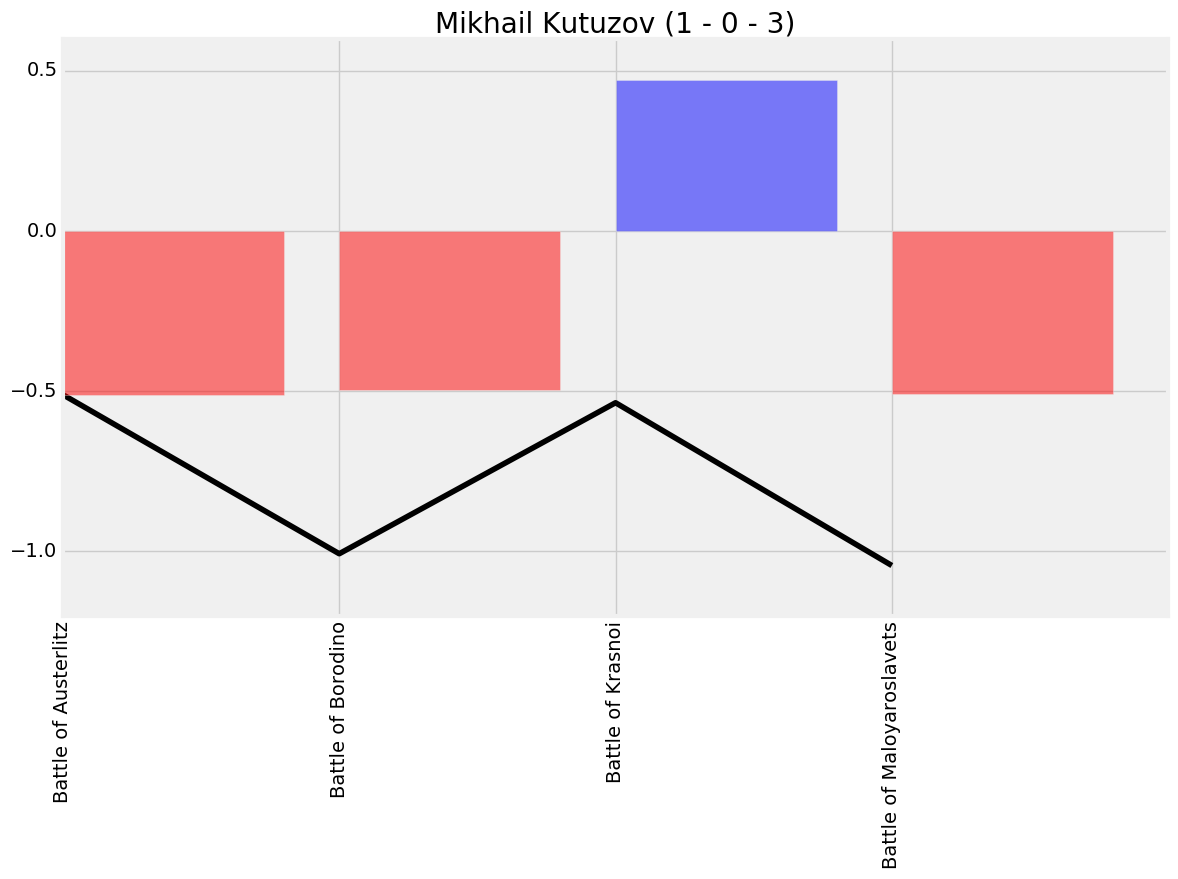

In [122]:
battle_list = []
graph('Mikhail Kutuzov')

In [123]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,Battle of Austerlitz,Mikhail Kutuzov,D,-0.510736,1805.0,-0.510736
1,Battle of Borodino,Mikhail Kutuzov,D,-0.496285,1812.0,-1.007021
2,Battle of Krasnoi,Mikhail Kutuzov,V,0.471229,1812.0,-0.535792
3,Battle of Maloyaroslavets,Mikhail Kutuzov,D,-0.508020,1812.0,-1.043812


In [124]:
df_model[df_model.Battle == 'Battle_of_Borodino'].transpose()

,920
Battle,Battle_of_Borodino
pos_x,L
VorD,V
Infantry_x,160000
Cavalry_x,0
Artillery_x,587
Ships_x,0
Airforce_x,0
Special_x,0
pos_y,R


In [125]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,Battle of Austerlitz,Mikhail Kutuzov,D,-0.510736,1805.0,-0.510736
1,Battle of Borodino,Mikhail Kutuzov,D,-0.496285,1812.0,-1.007021
2,Battle of Krasnoi,Mikhail Kutuzov,V,0.471229,1812.0,-0.535792
3,Battle of Maloyaroslavets,Mikhail Kutuzov,D,-0.508020,1812.0,-1.043812


In [126]:
df_war = pd.DataFrame(war_list).sort('WAR', ascending = False).reset_index(drop = True)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [127]:
df_war

,General,WAR
0,Julius Caesar,7.328932
1,Khalid ibn al-Walid,5.614187
2,Hannibal,5.459163
3,Oda Nobunaga,4.213096
4,Augustus,3.366716
5,Sarath Fonseka,2.934313
6,Thrasybulus,2.498061
7,Godfrey of Bouillon,2.455477
8,Ariel Sharon,2.133749
9,"Tancred, Prince of Galilee",2.022043


In [128]:
import seaborn as sns

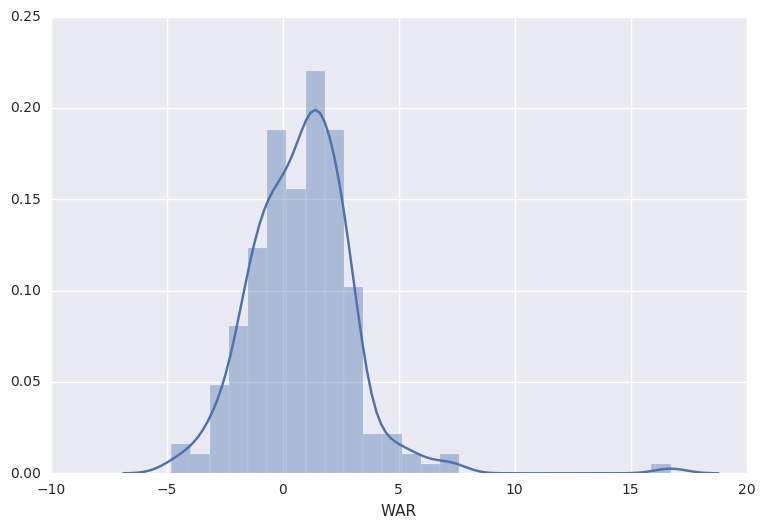

In [78]:
sns.distplot(df_war['WAR'])

In [79]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,Battle of Pensacola (1781),Francisco de Miranda,V,0.416037,1781.0,0.416037


In [129]:
import math

In [130]:
def bokeh(commander):
    battle_list = []
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    global df_battles
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    output_file('{}_bokeh_warg.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover])
    
    p.line(x = x, y = y_cum, source = source, line_width = 5)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = x, 
           top = y, 
           source = source, 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5)
    
    p.xaxis.major_label_orientation = math.pi/2
#     show(p)
    save(p)

<ipython-input-130-55a4e717de05>:26: SyntaxWarning: name 'df_battles' is assigned to before global declaration
  global df_battles


In [131]:
df_run[df_run.belligerent.str.contains('Khan')]

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special,year
69,Battle at Machhiwara,1555,Machhiwara,Decisive Mughal victory,Bairam Khan,"30,000",unknown,L,V,1.0,NaN,NaN,NaN,NaN,NaN,1555.0
384,Battle of Baghdad (1258),29 January – 10 February 1258 (13 days),"Baghdad, modern-day Iraq",Decisive Mongol victory,Hulagu Khan,"50,000","120,000[3]–150,000[4]",L,V,135000.0,NaN,NaN,NaN,NaN,NaN,1258.0
637,Battle of Buyur Lake,1388,"Buir Lake, China–Mongolia border",Decisive Ming victory,Uskhal Khan Tögüs Temür,"150,000 soldiers",---,R,D,1.0,NaN,NaN,NaN,NaN,NaN,1388.0
773,Battle of Chaldiran,23 August 1514,"Chaldiran, near Khoy, northwestern Iran",Decisive Ottoman victory[1]\r\r\r\nPolitical s...,Durmish Khan Shamlu,"60,000[5]\r\r\r\nor 100,000[6][7]\r\r\r\n100-1...","40,000[9][7]\r\r\r\nor 55,000[10]\r\r\r\nor 80...",R,D,60000.0,NaN,NaN,NaN,NaN,NaN,1514.0
775,Battle of Chaldiran,23 August 1514,"Chaldiran, near Khoy, northwestern Iran",Decisive Ottoman victory[1]\r\r\r\nPolitical s...,Mohammad Khan Ustajlu,"60,000[5]\r\r\r\nor 100,000[6][7]\r\r\r\n100-1...","40,000[9][7]\r\r\r\nor 55,000[10]\r\r\r\nor 80...",R,D,60000.0,NaN,NaN,NaN,NaN,NaN,1514.0
1332,Battle of Herat,"November 12, 2001","Herat, Afghanistan",Allied victory,Ismail Khan,NaN,"Northern Alliance: 5,000",R,V,5000.0,NaN,NaN,NaN,NaN,NaN,2001.0
1560,Battle of Kherlen,"September 23, 1409",Kherlen River,Eastern Mongol victory,Öljei Temür Khan,"1,000 cavalry",Unknown,L,V,1.0,NaN,NaN,NaN,NaN,NaN,1409.0
1695,Battle of Legnica,9 April 1241,"Legnickie Pole\r\r\r\n(present day Legnica, Po...",Decisive Mongol victory,Orda Khan,"Estimates include 2,000,[2] 3,800–4,300,[4][5]...","Between 2,000[1] and 8,000[2][3]",L,V,5000.0,NaN,NaN,NaN,NaN,NaN,1241.0
1736,Battle of Lipnic,"August 20, 1470","Lipnic, Moldova",Moldavian pyrrhic victory.,Ahmed Khan bin Küchük,unknown,unknown,R,D,1.0,NaN,NaN,NaN,NaN,NaN,1470.0
1911,Battle of Mohi,11 April 1241,"Sajó River, Hungary",Decisive Mongol victory,Batu Khan,"up to\r\r\r\n80,000[1]\r\r\r\nOther estimation...","up to\r\r\r\n70,000[8]\r\r\r\nOther estimation...",R,V,30000.0,NaN,NaN,NaN,NaN,NaN,1241.0


In [132]:
mka = df_run.loc[8965, 'belligerent']

In [133]:
mka

u'Mustafa Kemal Atat\xfcrk'

In [134]:
battle_list = []
bokeh(u'George S. Patton')

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.

  warn(message)
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
Supplying a user-defined data source AND iterable values to glyph methods is deprecated.

See https://github.com/bokeh/bokeh/issues/2056 for more information.



In [59]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [55]:
df_warchart = df_warchart.sort('Values', ascending = True)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [56]:
df_warchart

,Labels,Values
2,WAR From Battle = .49,0.49
1,Replacement-Level Performance = .51,0.51
0,Win = 1 War,1.00


In [57]:
df_warchart = df_warchart.iloc[::-1]

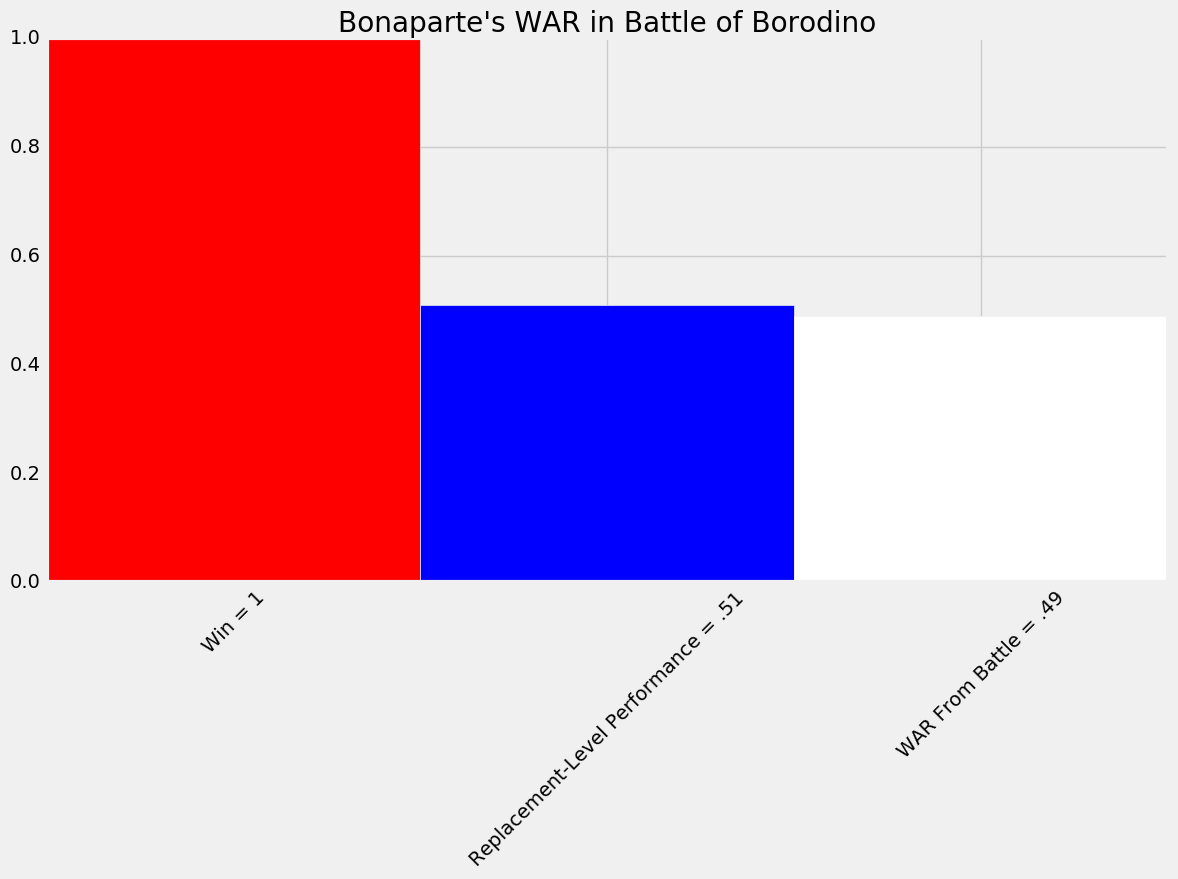

In [67]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'white'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.savefig('napoleon_war_sample')
plt.tight_layout()
# ax.set_axis_bgcolor('gray')

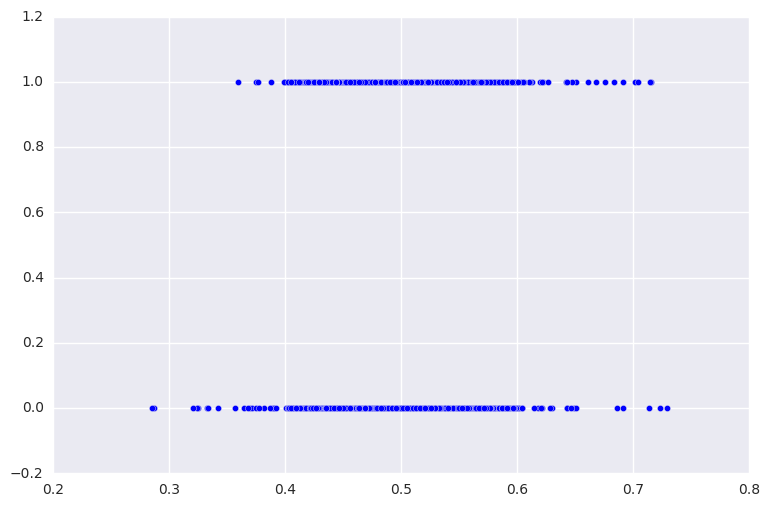

In [148]:
data = 

In [147]:
probas = pd.DataFrame(lr.predict_proba(df_x))[1]

In [144]:
df_y

,VorD
0,1.0
1,1.0
4,0.0
5,0.0
8,1.0
12,1.0
13,1.0
16,1.0
17,1.0
18,0.0
